<a href="https://colab.research.google.com/github/quagrain/quagrain/blob/main/OVR_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBRegressor
from google.colab import drive
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import pickle

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Importing Data**

In [3]:
path_21 = '/content/drive/My Drive/Colab Notebooks/datasets/players_21.csv'
path_22 = '/content/drive/My Drive/Colab Notebooks/datasets/players_22.csv'

with open(path_21) as dataset_21, open(path_22) as dataset_22:
    fifa_21 = pd.read_csv(path_21)
    fifa_22 = pd.read_csv(path_22, low_memory=False)

print("\nFIFA 21 Dataset Shape: " + str(fifa_21.shape))
print("FIFA 22 Dataset Shape: " + str(fifa_22.shape) + "\n")

drop = []
for col in fifa_21.columns:
    missing = (len(fifa_21[col]) - fifa_21[col].count())/len(fifa_21[col]) * 100
    if missing > 30:
        print(f'{col} = {round(missing, 2)}%')
        drop.append(col)

fifa_21.drop(columns = drop, inplace = True)
fifa_22.drop(columns = drop, inplace = True)

print("\nFIFA 21 Dataset Shape: " + str(fifa_21.shape))
print("FIFA 22 Dataset Shape: " + str(fifa_22.shape) + "\n")


FIFA 21 Dataset Shape: (18944, 110)
FIFA 22 Dataset Shape: (19239, 110)

club_loaned_from = 96.0%
nation_team_id = 94.05%
nation_position = 94.05%
nation_jersey_number = 94.05%
player_tags = 92.57%
player_traits = 56.11%
goalkeeping_speed = 89.0%
nation_logo_url = 94.05%

FIFA 21 Dataset Shape: (18944, 102)
FIFA 22 Dataset Shape: (19239, 102)



We are dropping all the columns that have more than 30% of their values missing because imputing them could create a bias.

# **Exploratory Data Analysis**

In [4]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Player Age Distribution')

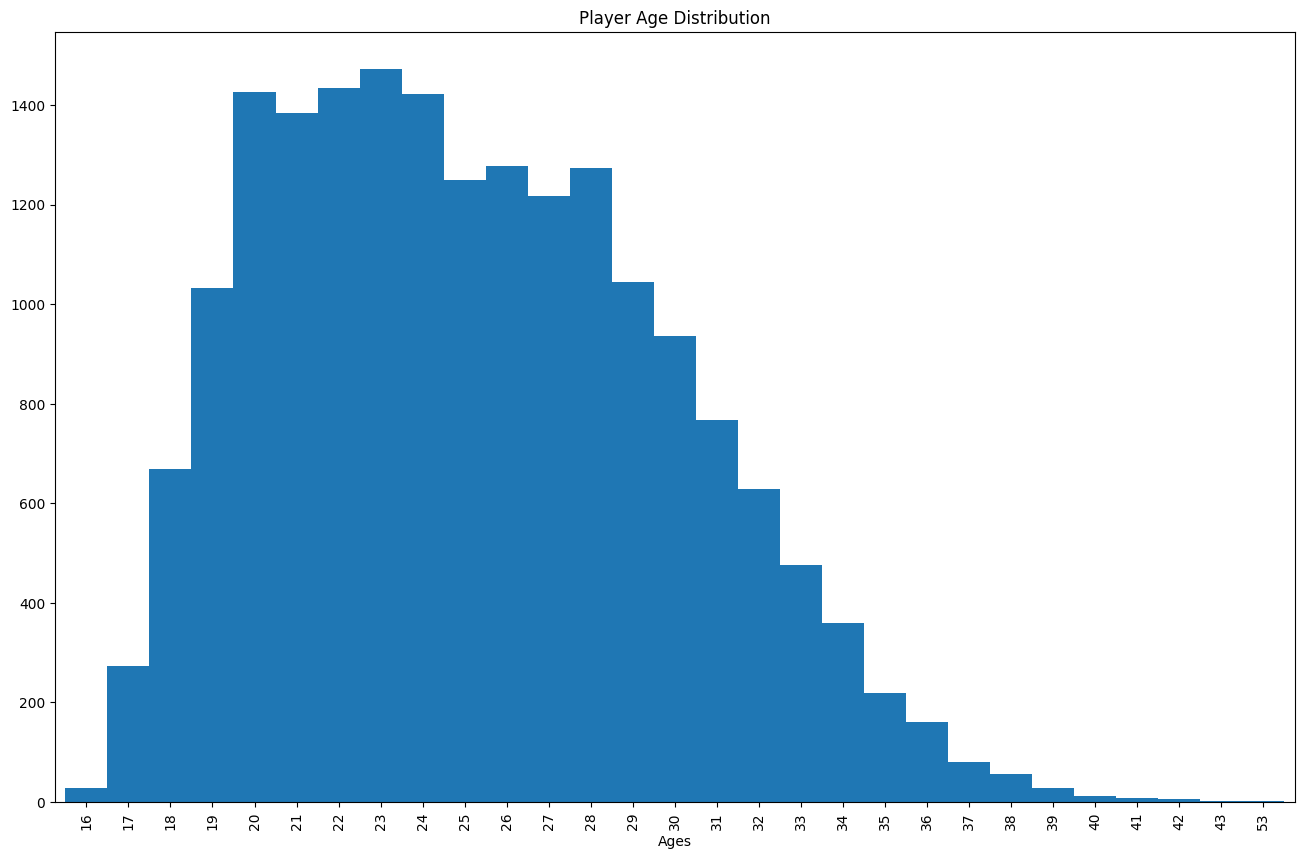

In [5]:
age = fifa_21['age']
bins=np.arange(0, 60, 1)
pd.cut(age, bins=bins, labels=bins[1:]).astype(int).value_counts().sort_index().plot.bar(width=1, figsize=(16,10))
plt.xlabel('Ages')
plt.xticks(rotation=90)
plt.title('Player Age Distribution')

<Axes: xlabel='overall', ylabel='wage_eur'>

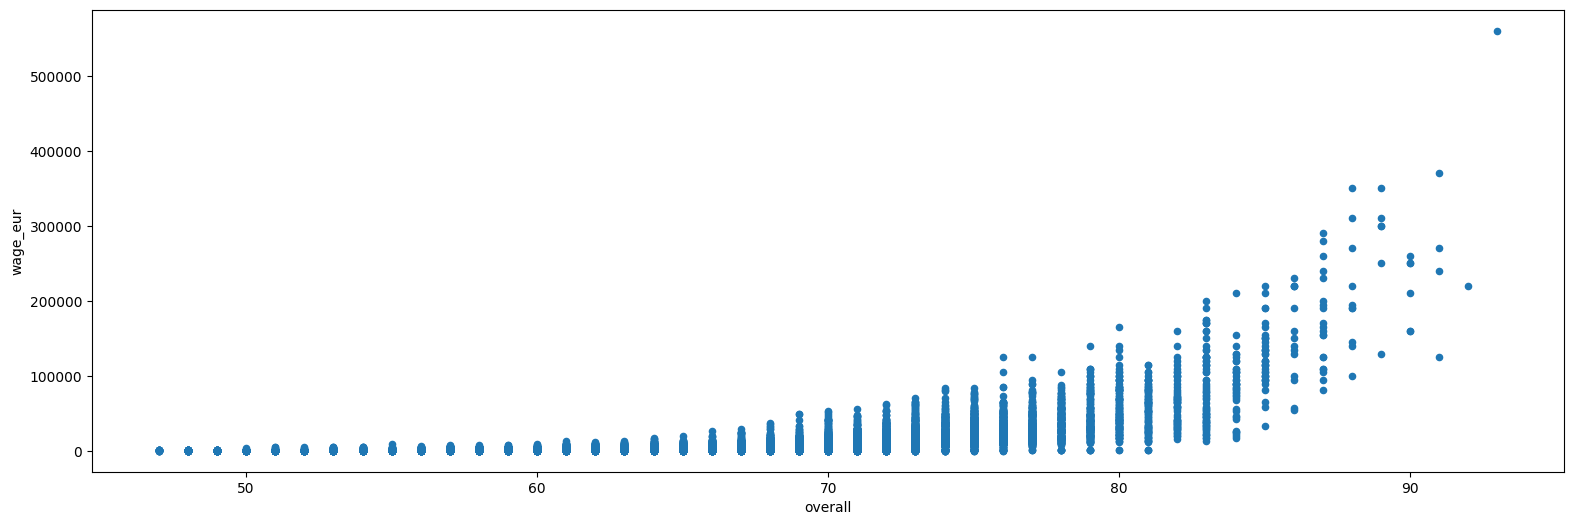

In [6]:
fifa_21.plot(kind="scatter", x="overall", y="wage_eur", figsize=(19,6))

<Axes: xlabel='overall', ylabel='value_eur'>

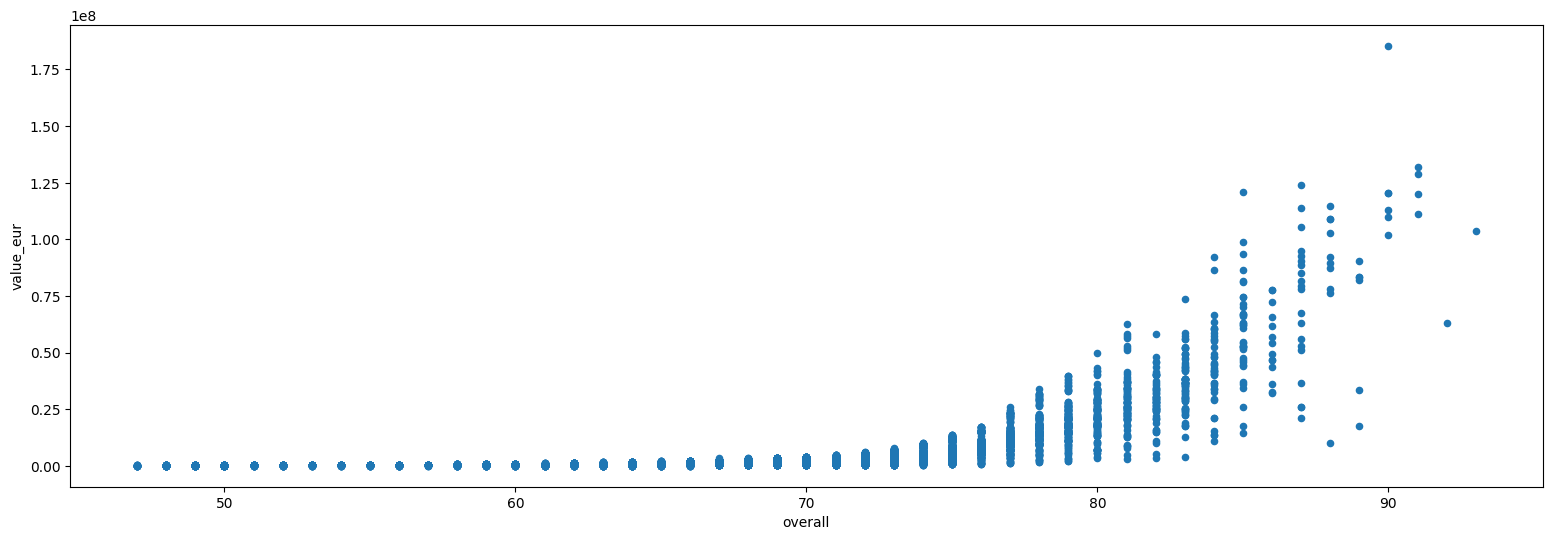

In [7]:
fifa_21.plot(kind="scatter", x="overall", y="value_eur", figsize=(19,6))

<Axes: xlabel='potential', ylabel='overall'>

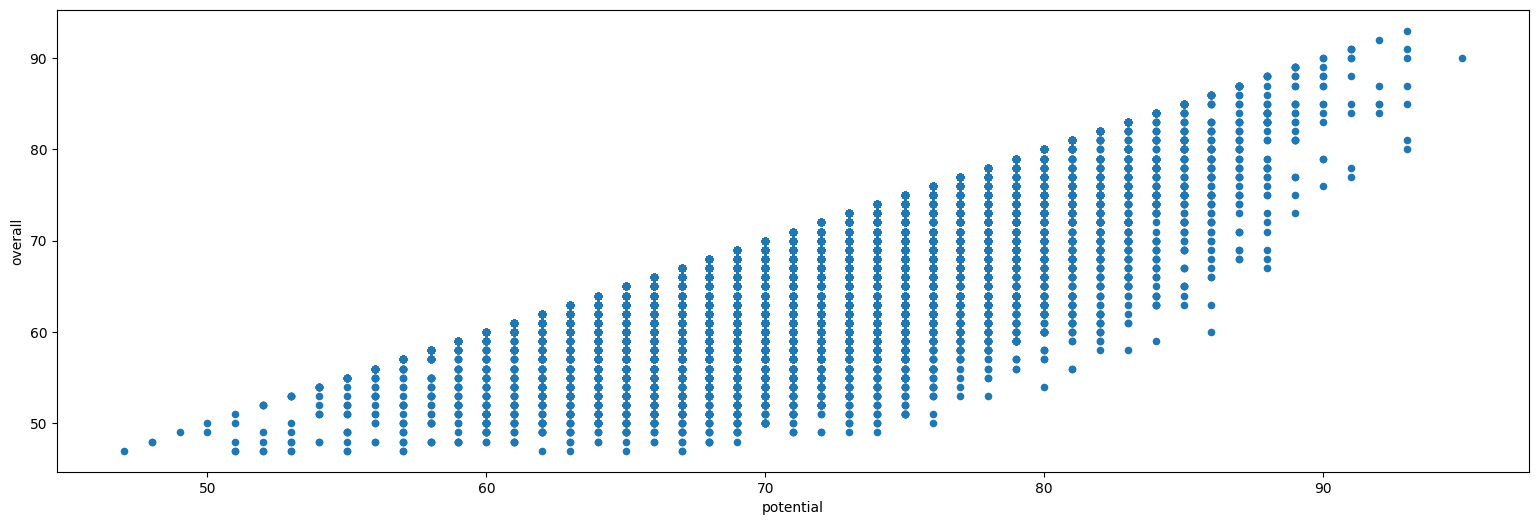

In [9]:
fifa_21.plot(kind="scatter", x="potential", y="overall", figsize=(19,6))

error: open("drive/MyDrive/ (Responses).gsheet"): Operation not supported
error: unable to index file 'drive/MyDrive/ (Responses).gsheet'
fatal: adding files failed


# **Subsetting Data**

In [49]:
ovr_21 = fifa_21[['overall']]
ovr_22 = fifa_22[['overall']]
correlate = fifa_21.corr(numeric_only = True)['overall'].sort_values(ascending=False)
keys = correlate.keys()
values = correlate.values
keys_to_use = []
for key,val in zip(keys, values):
    if(val>0.4): # 0.1
        keys_to_use.append(key)
keys_to_use.remove('potential')
keys_to_use.remove('release_clause_eur')
keys_to_use.remove('wage_eur')
keys_to_use.remove('value_eur')
keys_to_use.remove('international_reputation')

train_21 = fifa_21[keys_to_use]
train_22 = fifa_22[keys_to_use]
ovr_21 = train_21['overall']
ovr_22 = train_22['overall']

Imputation

In [8]:
imp = SimpleImputer()
imp.fit(train_21)
imputed_data=imp.fit_transform(train_21)
train_21_imp=pd.DataFrame(imputed_data, columns=train_21.columns)

imputed_data = imp.fit_transform(train_22)
train_22_imp=pd.DataFrame(imputed_data, columns=train_22.columns)

Encoding

In [10]:
categorical = ['work_rate']
labels_21 = fifa_21[categorical]
labels_22 = fifa_22[categorical]
encoder = LabelEncoder()
labels_21 = pd.DataFrame(encoder.fit_transform(labels_21), columns = labels_21.columns)
labels_22 = pd.DataFrame(encoder.fit_transform(labels_22), columns = labels_22.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Scaling

In [11]:
train_21_imp.drop(columns='overall', inplace=True)
train_22_imp.drop(columns='overall', inplace=True)

In [12]:
sc = StandardScaler()
scaled = sc.fit_transform(train_21_imp)
train_21 = pd.DataFrame(scaled, columns = train_21_imp.columns)

scaled = sc.fit_transform(train_22_imp)
train_22 = pd.DataFrame(scaled, columns = train_22_imp.columns)

Randomise the arrangement of the rows in each dataframe

In [13]:
train_21 = pd.concat([train_21, ovr_21], axis = 1).sample(frac=1)
train_22 = pd.concat([train_22, ovr_22], axis = 1).sample(frac=1)

In [14]:
ovr_21 = train_21['overall']
ovr_22 = train_22['overall']
train_21.drop(columns='overall', inplace=True)
train_22.drop(columns='overall', inplace=True)

# **Model Training**

In [16]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
xgb_reg = XGBRegressor(n_estimators = 1000, verbosity = 1,max_depth = 5, gamma = 0.2, subsample = 0.2, learning_rate = 0.3)
g_reg = GradientBoostingRegressor(random_state=42)
sv = SVR()
knn = KNeighborsRegressor()
vc = VotingRegressor(estimators=[('random_forest', rf), ('xgb', g_reg), ('svm', sv), ('knn', knn)])

In [18]:
for reg in (rf, xgb_reg, g_reg, sv, knn, vc):
    Xtrain,Xtest,Ytrain,Ytest=train_test_split(train_21,ovr_21,test_size=0.2,random_state=42)
    reg.fit(Xtrain, Ytrain)
    y_pred = reg.predict(Xtest)
    mse = mean_squared_error(y_pred, Ytest)
    mae = mean_absolute_error(y_pred, Ytest)
    r2 = r2_score(y_pred, Ytest)
    print(f"The {reg.__class__.__name__} model had {round(mse, 4)} MSE, {round(mae, 4)} MAE and {round(r2, 4)} R2 Score")

The RandomForestRegressor model had 4.0606 MSE, 1.5235 MAE and 0.906 R2 Score
The XGBRegressor model had 6.8593 MSE, 1.9734 MAE and 0.8597 R2 Score
The GradientBoostingRegressor model had 4.7382 MSE, 1.6716 MAE and 0.8889 R2 Score
The SVR model had 3.6568 MSE, 1.4328 MAE and 0.9165 R2 Score
The KNeighborsRegressor model had 4.9695 MSE, 1.6988 MAE and 0.8792 R2 Score
The VotingRegressor model had 3.7446 MSE, 1.466 MAE and 0.9111 R2 Score


In [19]:
for reg in (rf, xgb_reg, g_reg, sv, knn, vc):
    y_pred = reg.predict(train_22)
    mse = mean_squared_error(ovr_22, y_pred)
    mae = mean_absolute_error(ovr_22, y_pred)
    r2 = r2_score(ovr_22, y_pred)
    print(f"The {reg.__class__.__name__} model had {round(mse, 4)} MSE, {round(mae, 4)} MAE and {round(r2, 4)} R2 Score")

The RandomForestRegressor model had 3.0877 MSE, 1.3066 MAE and 0.9348 R2 Score
The XGBRegressor model had 6.3978 MSE, 1.9148 MAE and 0.8648 R2 Score
The GradientBoostingRegressor model had 4.2211 MSE, 1.5747 MAE and 0.9108 R2 Score
The SVR model had 3.351 MSE, 1.3667 MAE and 0.9292 R2 Score
The KNeighborsRegressor model had 4.2516 MSE, 1.5657 MAE and 0.9102 R2 Score
The VotingRegressor model had 3.1528 MSE, 1.3406 MAE and 0.9334 R2 Score


In [20]:
from sklearn.model_selection import KFold,GridSearchCV

In [21]:
cv=KFold(n_splits=3)
param_grid = [
{'bootstrap': [True], 'n_estimators': [10, 30 ,50, 100, 200], 'max_features': [3, 10, 20]},
{'bootstrap': [False], 'n_estimators': [10, 30 ,50, 100, 200], 'max_features': [3, 10, 20]},
]
grid_search = GridSearchCV(rf, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(train_21, ovr_21)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             param_grid=[{'bootstrap': [True], 'max_features': [3, 10, 20],
                          'n_estimators': [10, 30, 50, 100, 200]},
                         {'bootstrap': [False], 'max_features': [3, 10, 20],
                          'n_estimators': [10, 30, 50, 100, 200]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [22]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 3, 'n_estimators': 200}

In [37]:
model = grid_search.best_estimator_

In [38]:
y_pred = model.predict(train_22)

In [39]:
model.score(train_22, ovr_22)

0.9493927124384753

In [42]:
np.sqrt(mean_squared_error(ovr_22, y_pred))

1.5477410271169898

In [41]:
mean_absolute_error(ovr_22, y_pred)

1.1288700036384427

In [ ]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(sc, file)

In [ ]:
y_pred

array([72.57 , 54.05 , 52.935, ..., 60.495, 58.435, 61.07 ])